In [1]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attack_space"] = row["strategy"].split("-")[0]
    d["policy"] = "-".join(row["strategy"].split("-")[1:])
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_reward"] = reward[0]
    d["attacker_reward_per_time"] = reward[0] / row.head_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d["da_observed_pow_interval"] = row.head_time / (row.head_height * row.k)
    d["da_target_pow_interval"] = 1
    d["da_head_time"] = (
        row.head_time / d["da_observed_pow_interval"] * d["da_target_pow_interval"]
    )
    d["da_attacker_reward_per_time"] = reward[0] / d["da_head_time"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

d = df.query('protocol in ["tailstormll", "tailstorm"]')
d = d[(d.incentive_scheme == "constant") | (d.incentive_scheme == "discount")]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'head_time', 'head_height', 'head_progress',
       'machine_duration_s', 'error', 'version', 'attack_space', 'policy',
       'attacker_compute', 'attacker_relative_activations',
       'attacker_relative_reward', 'attacker_gain', 'attacker_reward',
       'attacker_reward_per_time', 'da_observed_pow_interval',
       'da_target_pow_interval', 'da_head_time',
       'da_attacker_reward_per_time'],
      dtype='object')

In [2]:
d.pivot(
    index=["network", "attacker_compute", "k"],
    columns=["protocol", "strategy", "incentive_scheme"],
    values="attacker_relative_reward",
)

protocol                                  tailstorm                     \
strategy                       ssz-override-catchup ssz-override-block   
incentive_scheme                           constant           constant   
network    attacker_compute k                                            
gamma-0    0.1              1              0.000000           0.000000   
                            2              0.009780           0.011517   
                            4              0.010865           0.011842   
                            8              0.006422           0.013484   
                            16             0.012832           0.007067   
...                                             ...                ...   
two-agents 0.5              2              0.934643           0.741015   
                            4              0.897702           0.696061   
                            8              0.927036           0.673507   
                            16             0.853650           0.671141   
                            32             0.741616           0.683847   

protocol                                                     \
strategy                       ssz-release-block ssz-honest   
incentive_scheme                        constant   constant   
network    attacker_compute k                                 
gamma-0    0.1              1           0.098400   0.099500   
                            2           0.098620   0.097000   
                            4           0.099200   0.101300   
                            8           0.094800   0.096600   
                            16          0.098600   0.100500   
...                                          ...        ...   
two-agents 0.5              2           0.510000   0.505200   
                            4           0.505000   0.506700   
                            8           0.508500   0.494100   
                            16          0.511900   0.504000   
                            32          0.502404   0.489083   

protocol                                                                \
strategy                       ssz-override-catchup ssz-override-block   
incentive_scheme                           discount           discount   
network    attacker_compute k                                            
gamma-0    0.1              1              0.000000           0.000000   
                            2              0.008382           0.008136   
                            4              0.014330           0.014241   
                            8              0.012533           0.011409   
                            16             0.011297           0.008921   
...                                             ...                ...   
two-agents 0.5              2              0.900038           0.742455   
                            4              0.919215           0.709234   
                            8              0.984922           0.684847   
                            16             0.891419           0.682064   
                            32             0.921930           0.697437   

protocol                                                     \
strategy                       ssz-release-block ssz-honest   
incentive_scheme                        discount   discount   
network    attacker_compute k                                 
gamma-0    0.1              1           0.101100   0.100300   
                            2           0.080601   0.095300   
                            4           0.089454   0.100500   
                            8           0.088024   0.100800   
                            16          0.090591   0.104500   
...                                          ...        ...   
two-agents 0.5              2           0.502064   0.497600   
                            4           0.508400   0.499300   
                            8           0.496770   0.501200   
             

Check if orphans align across discount schemes (Tailstorm/ll)

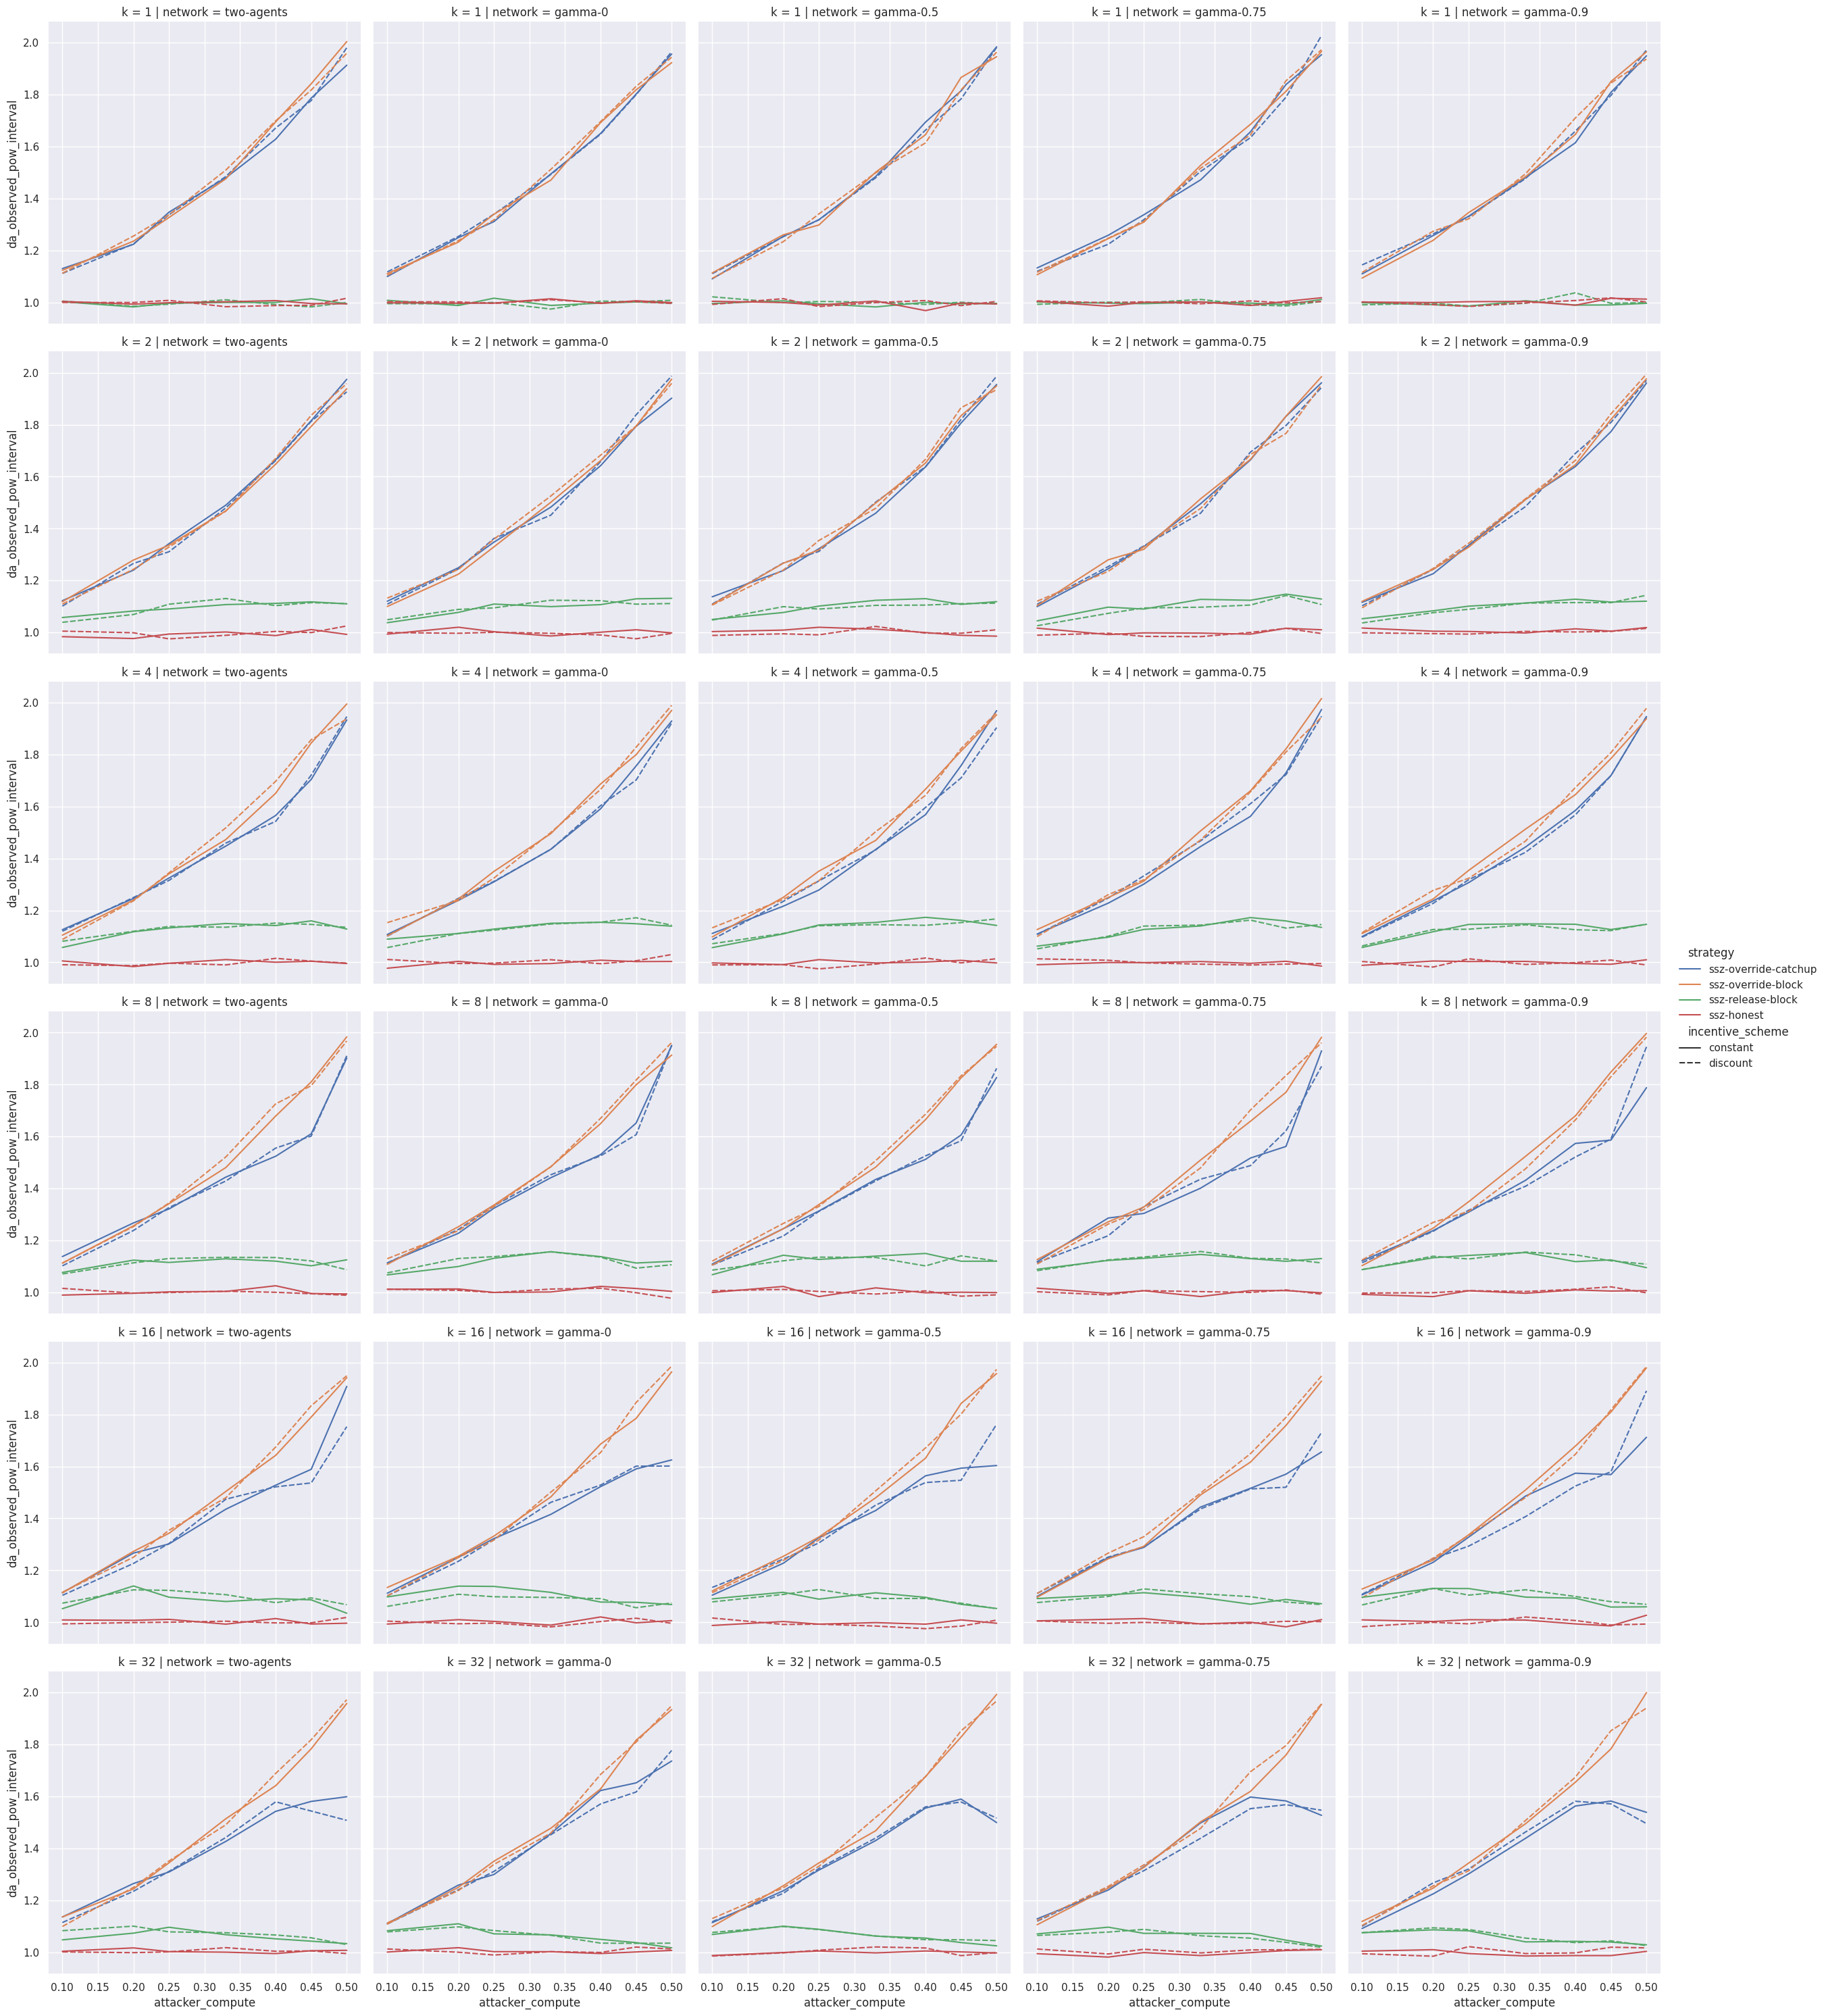

In [3]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and protocol == "tailstormll"'),
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="network",
    row="k",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

Check if orphans align across discount schemes (Tailstorm)

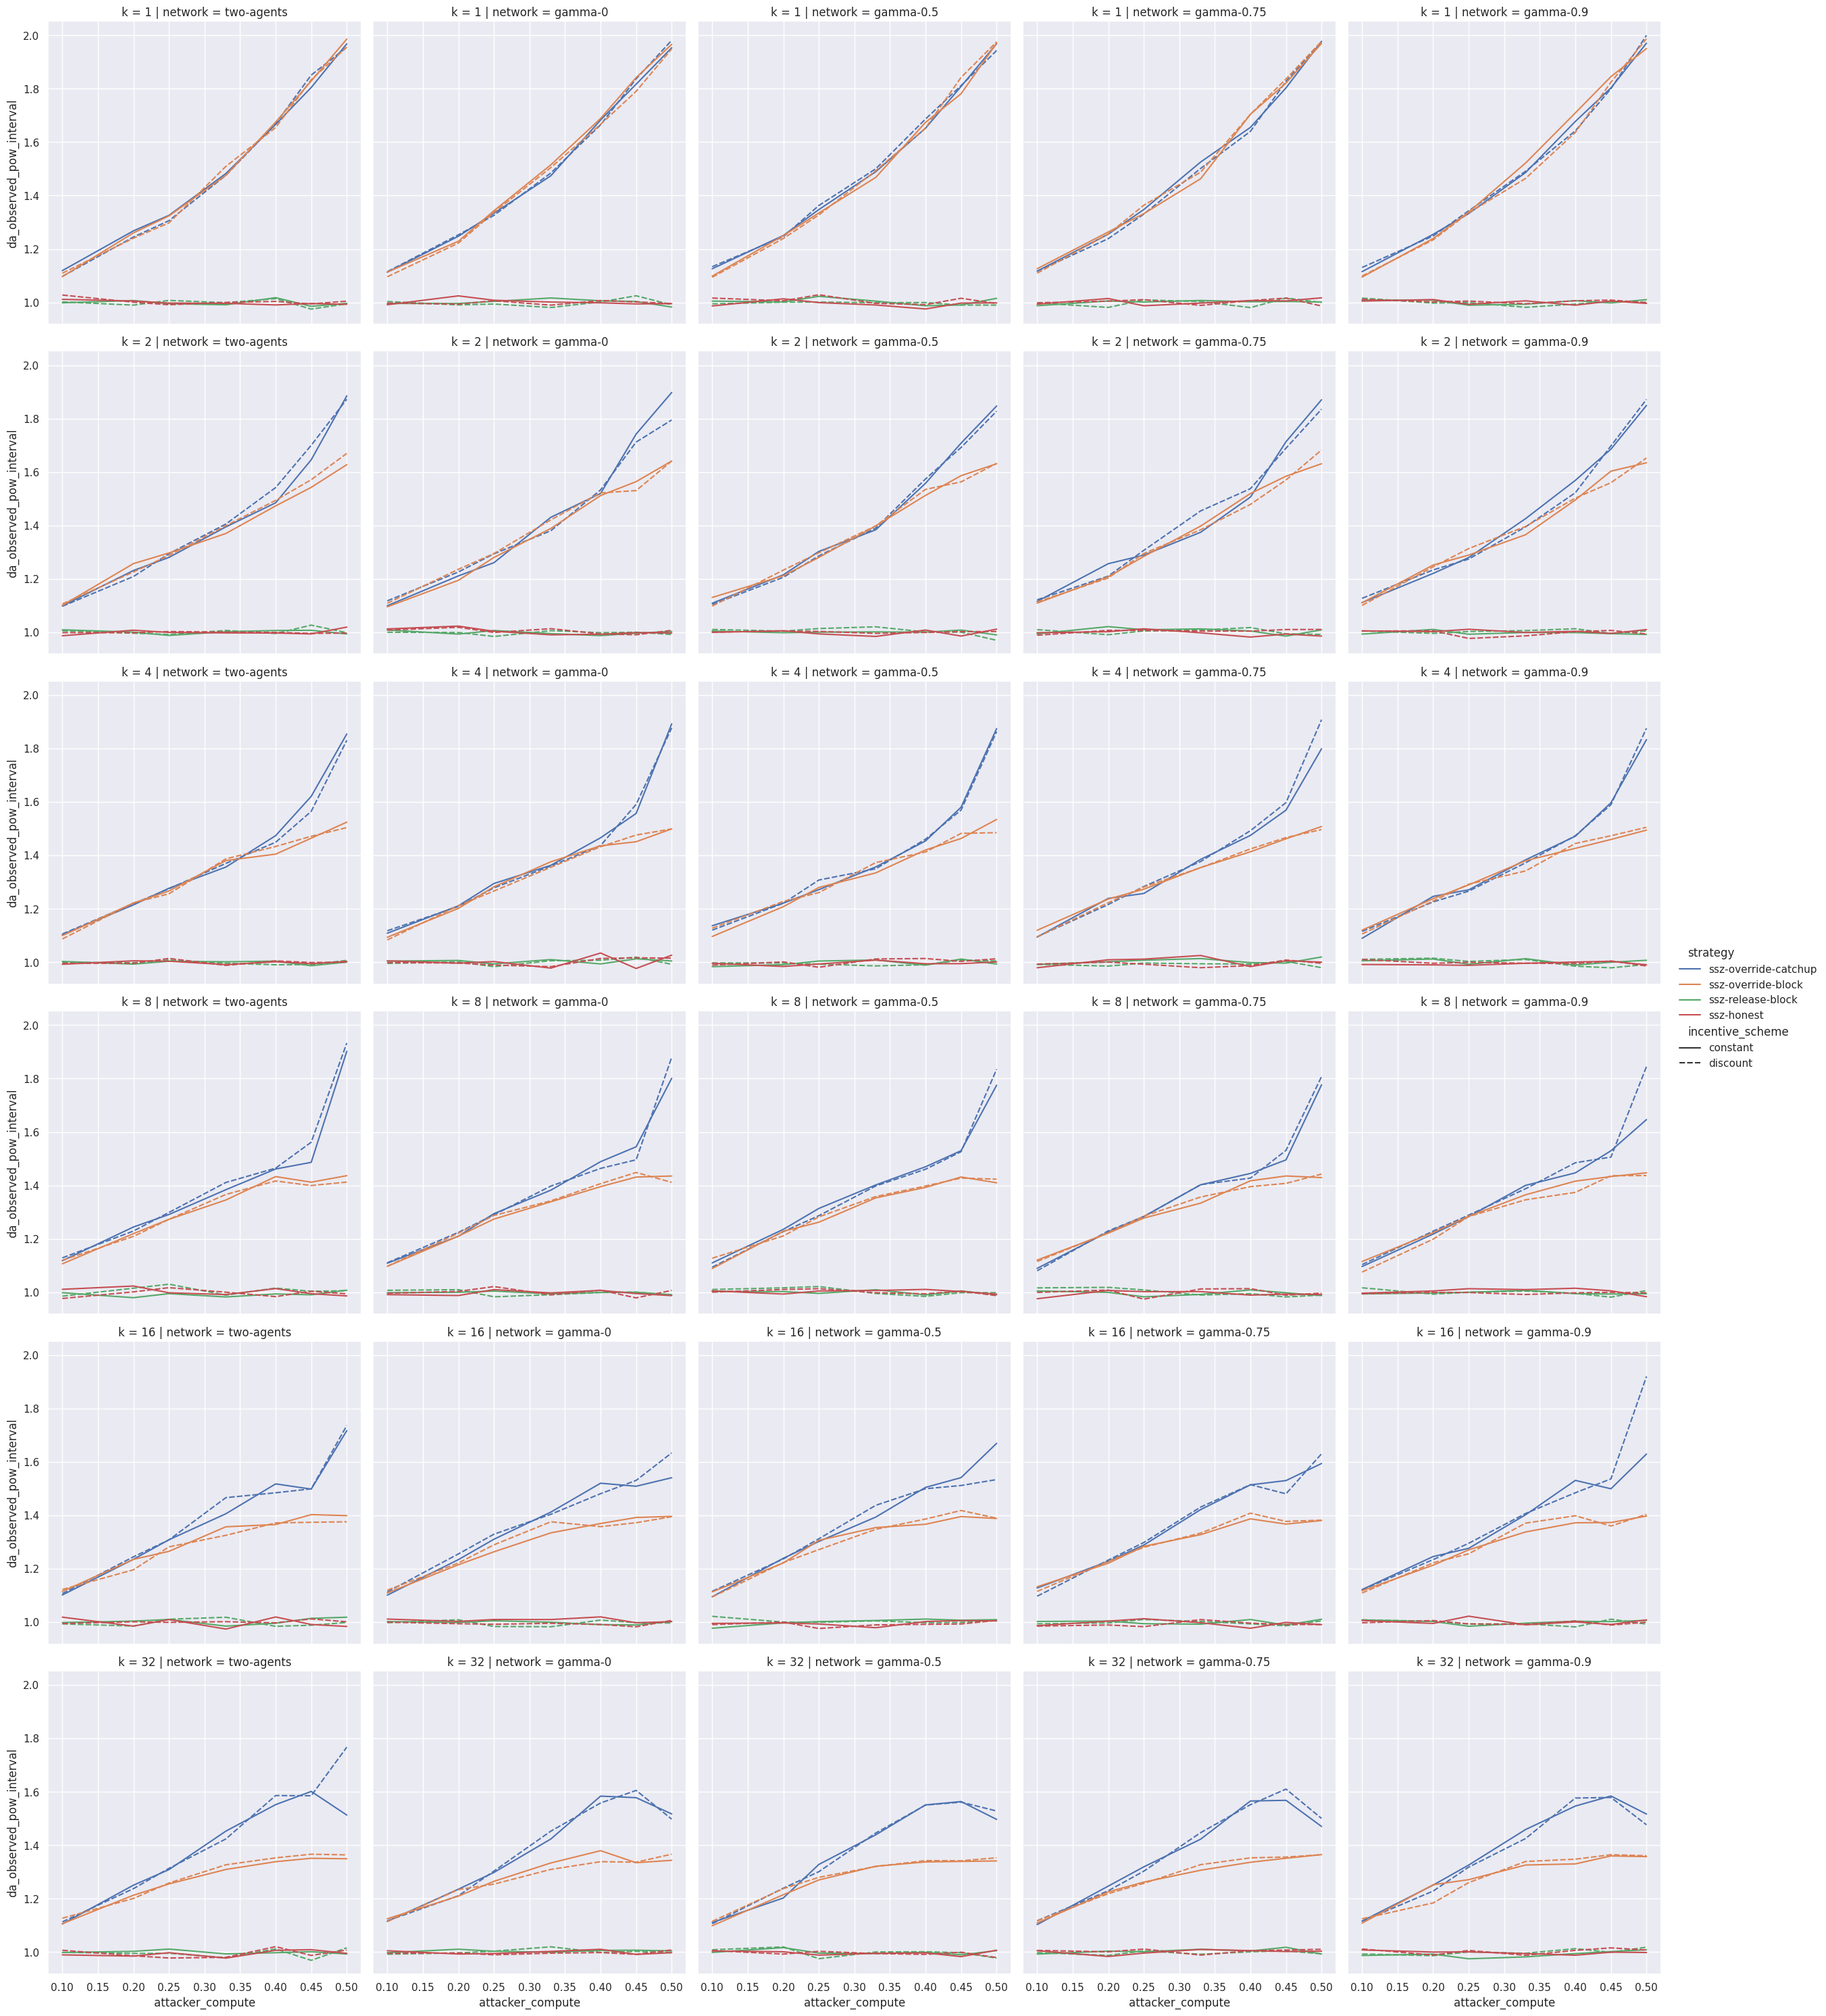

In [4]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and protocol == "tailstorm"'),
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="network",
    row="k",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

There seems to be no difference between the incenctive schemes. This is good.

Check difference between protocol implementations.

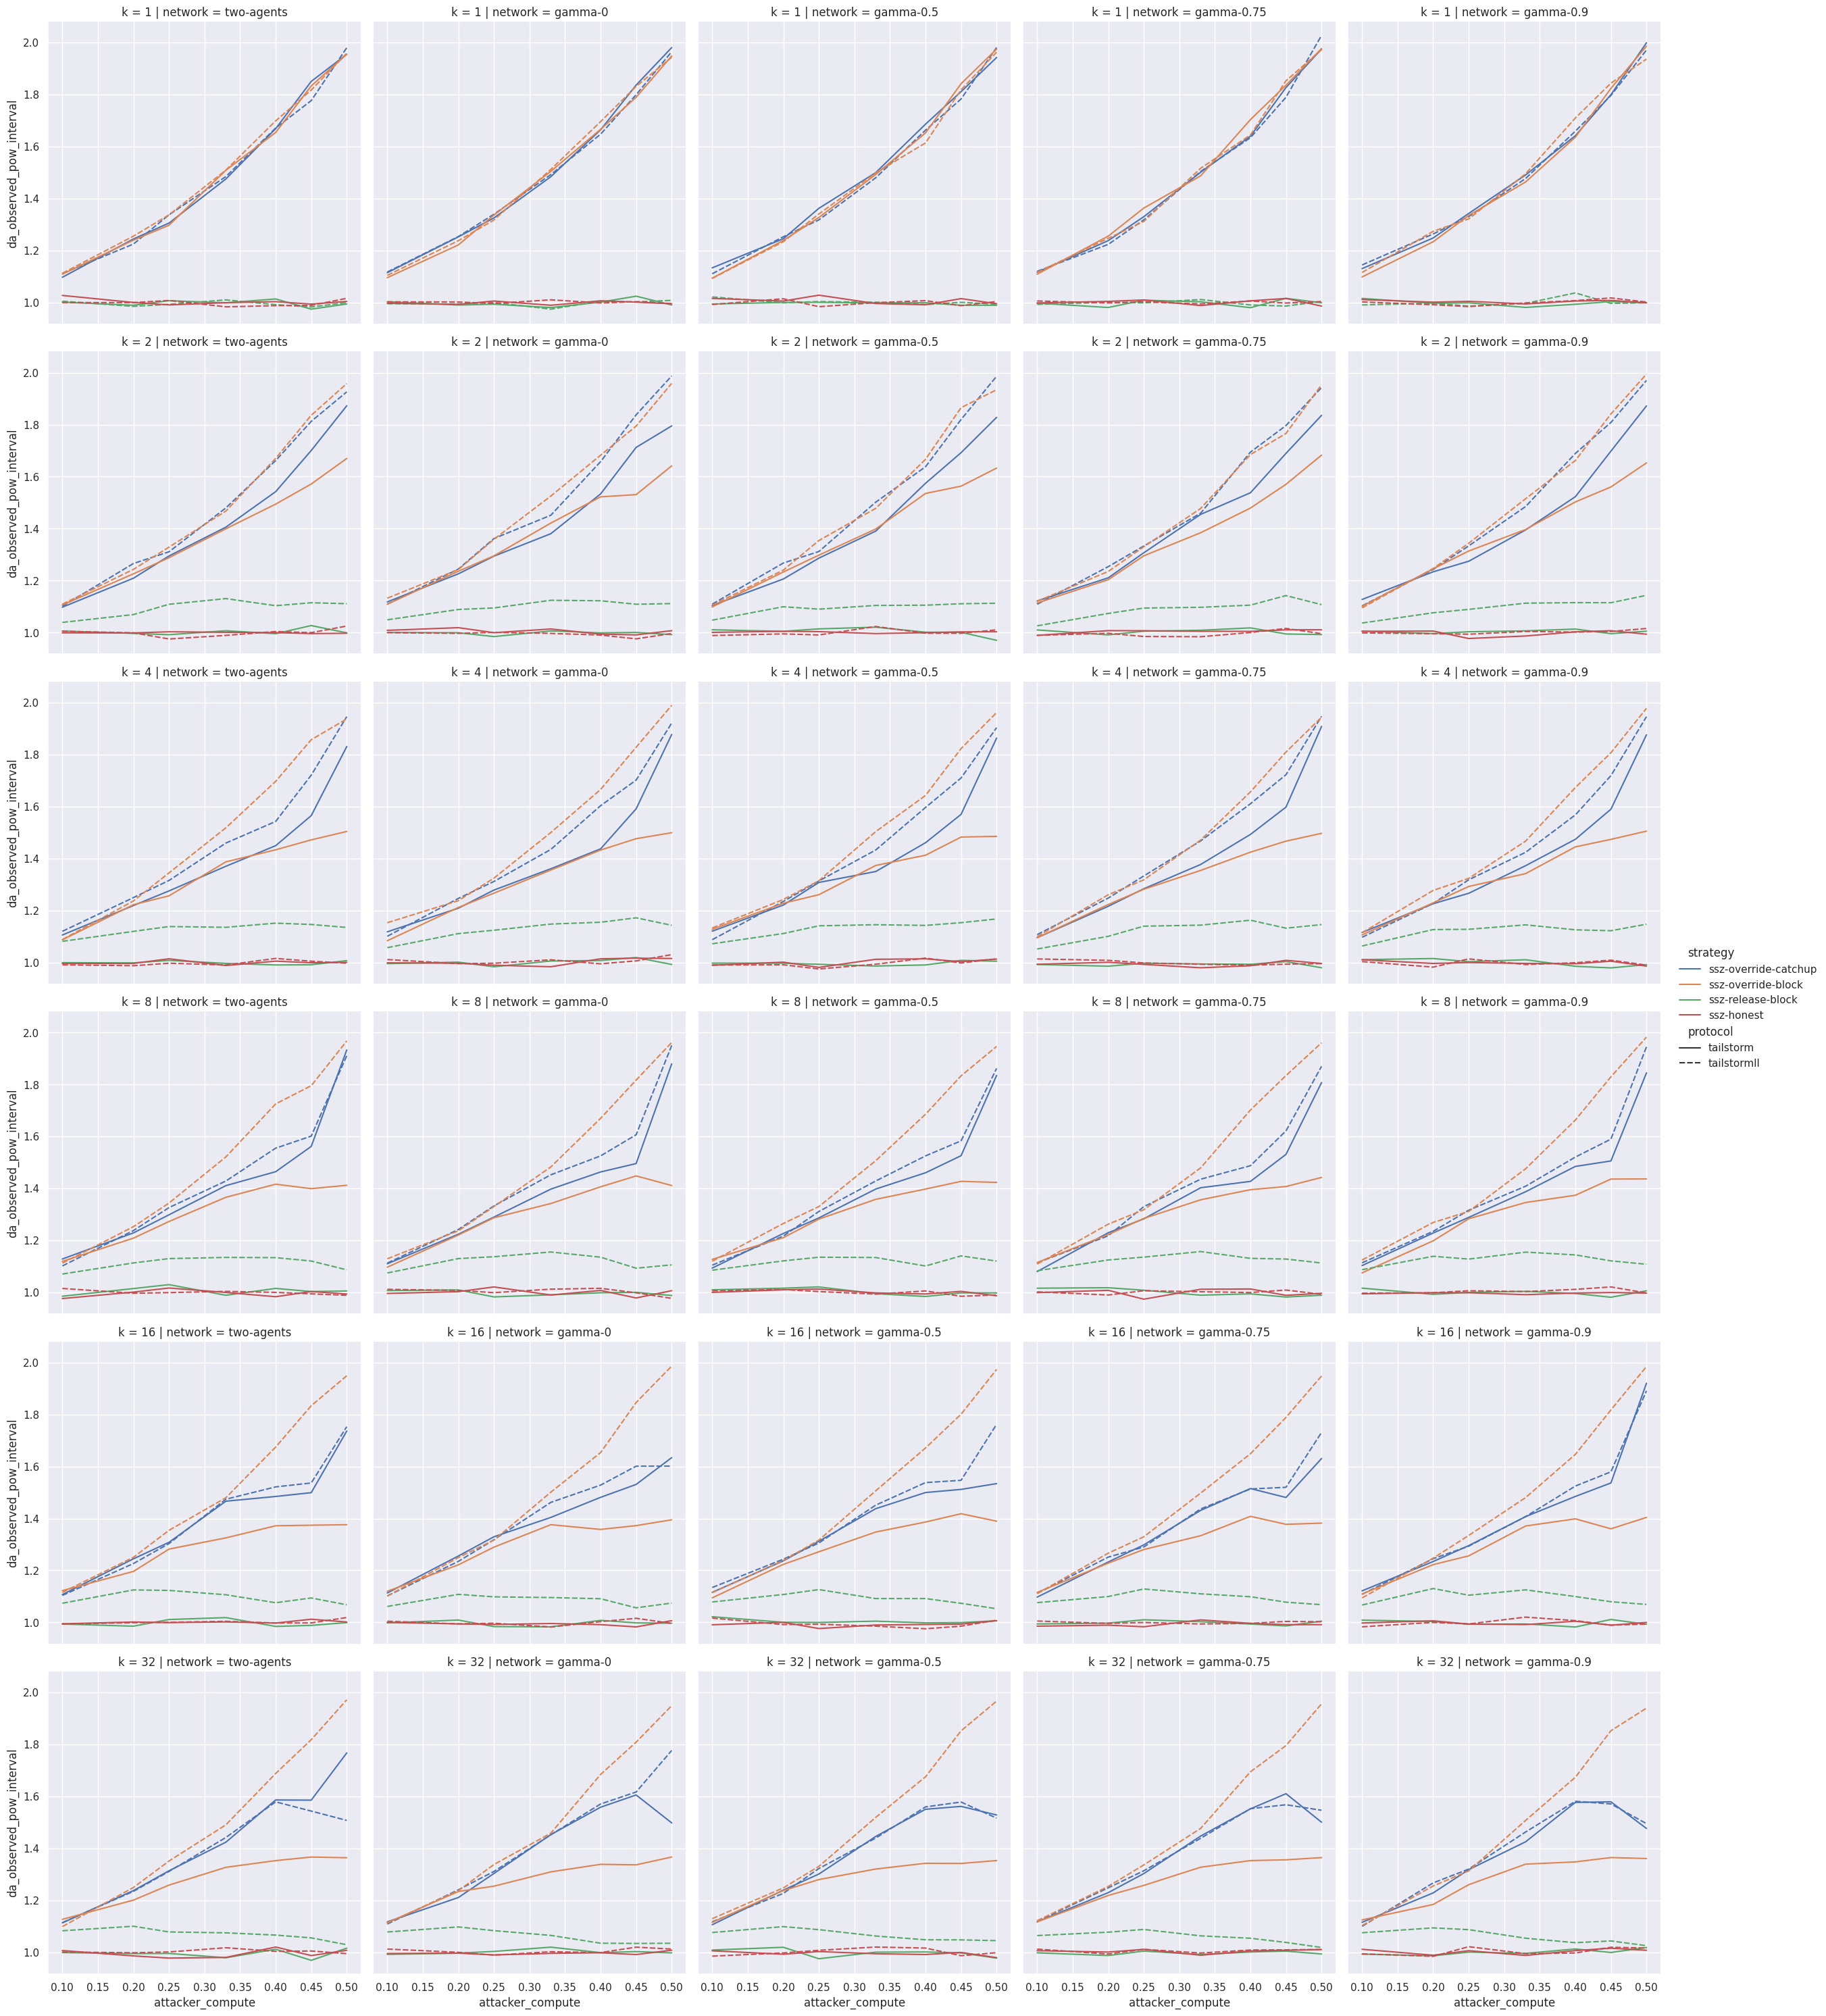

In [5]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="network",
    row="k",
    hue="strategy",
    style="protocol",
    kind="line",
)

Let's have a look whether there are long forks

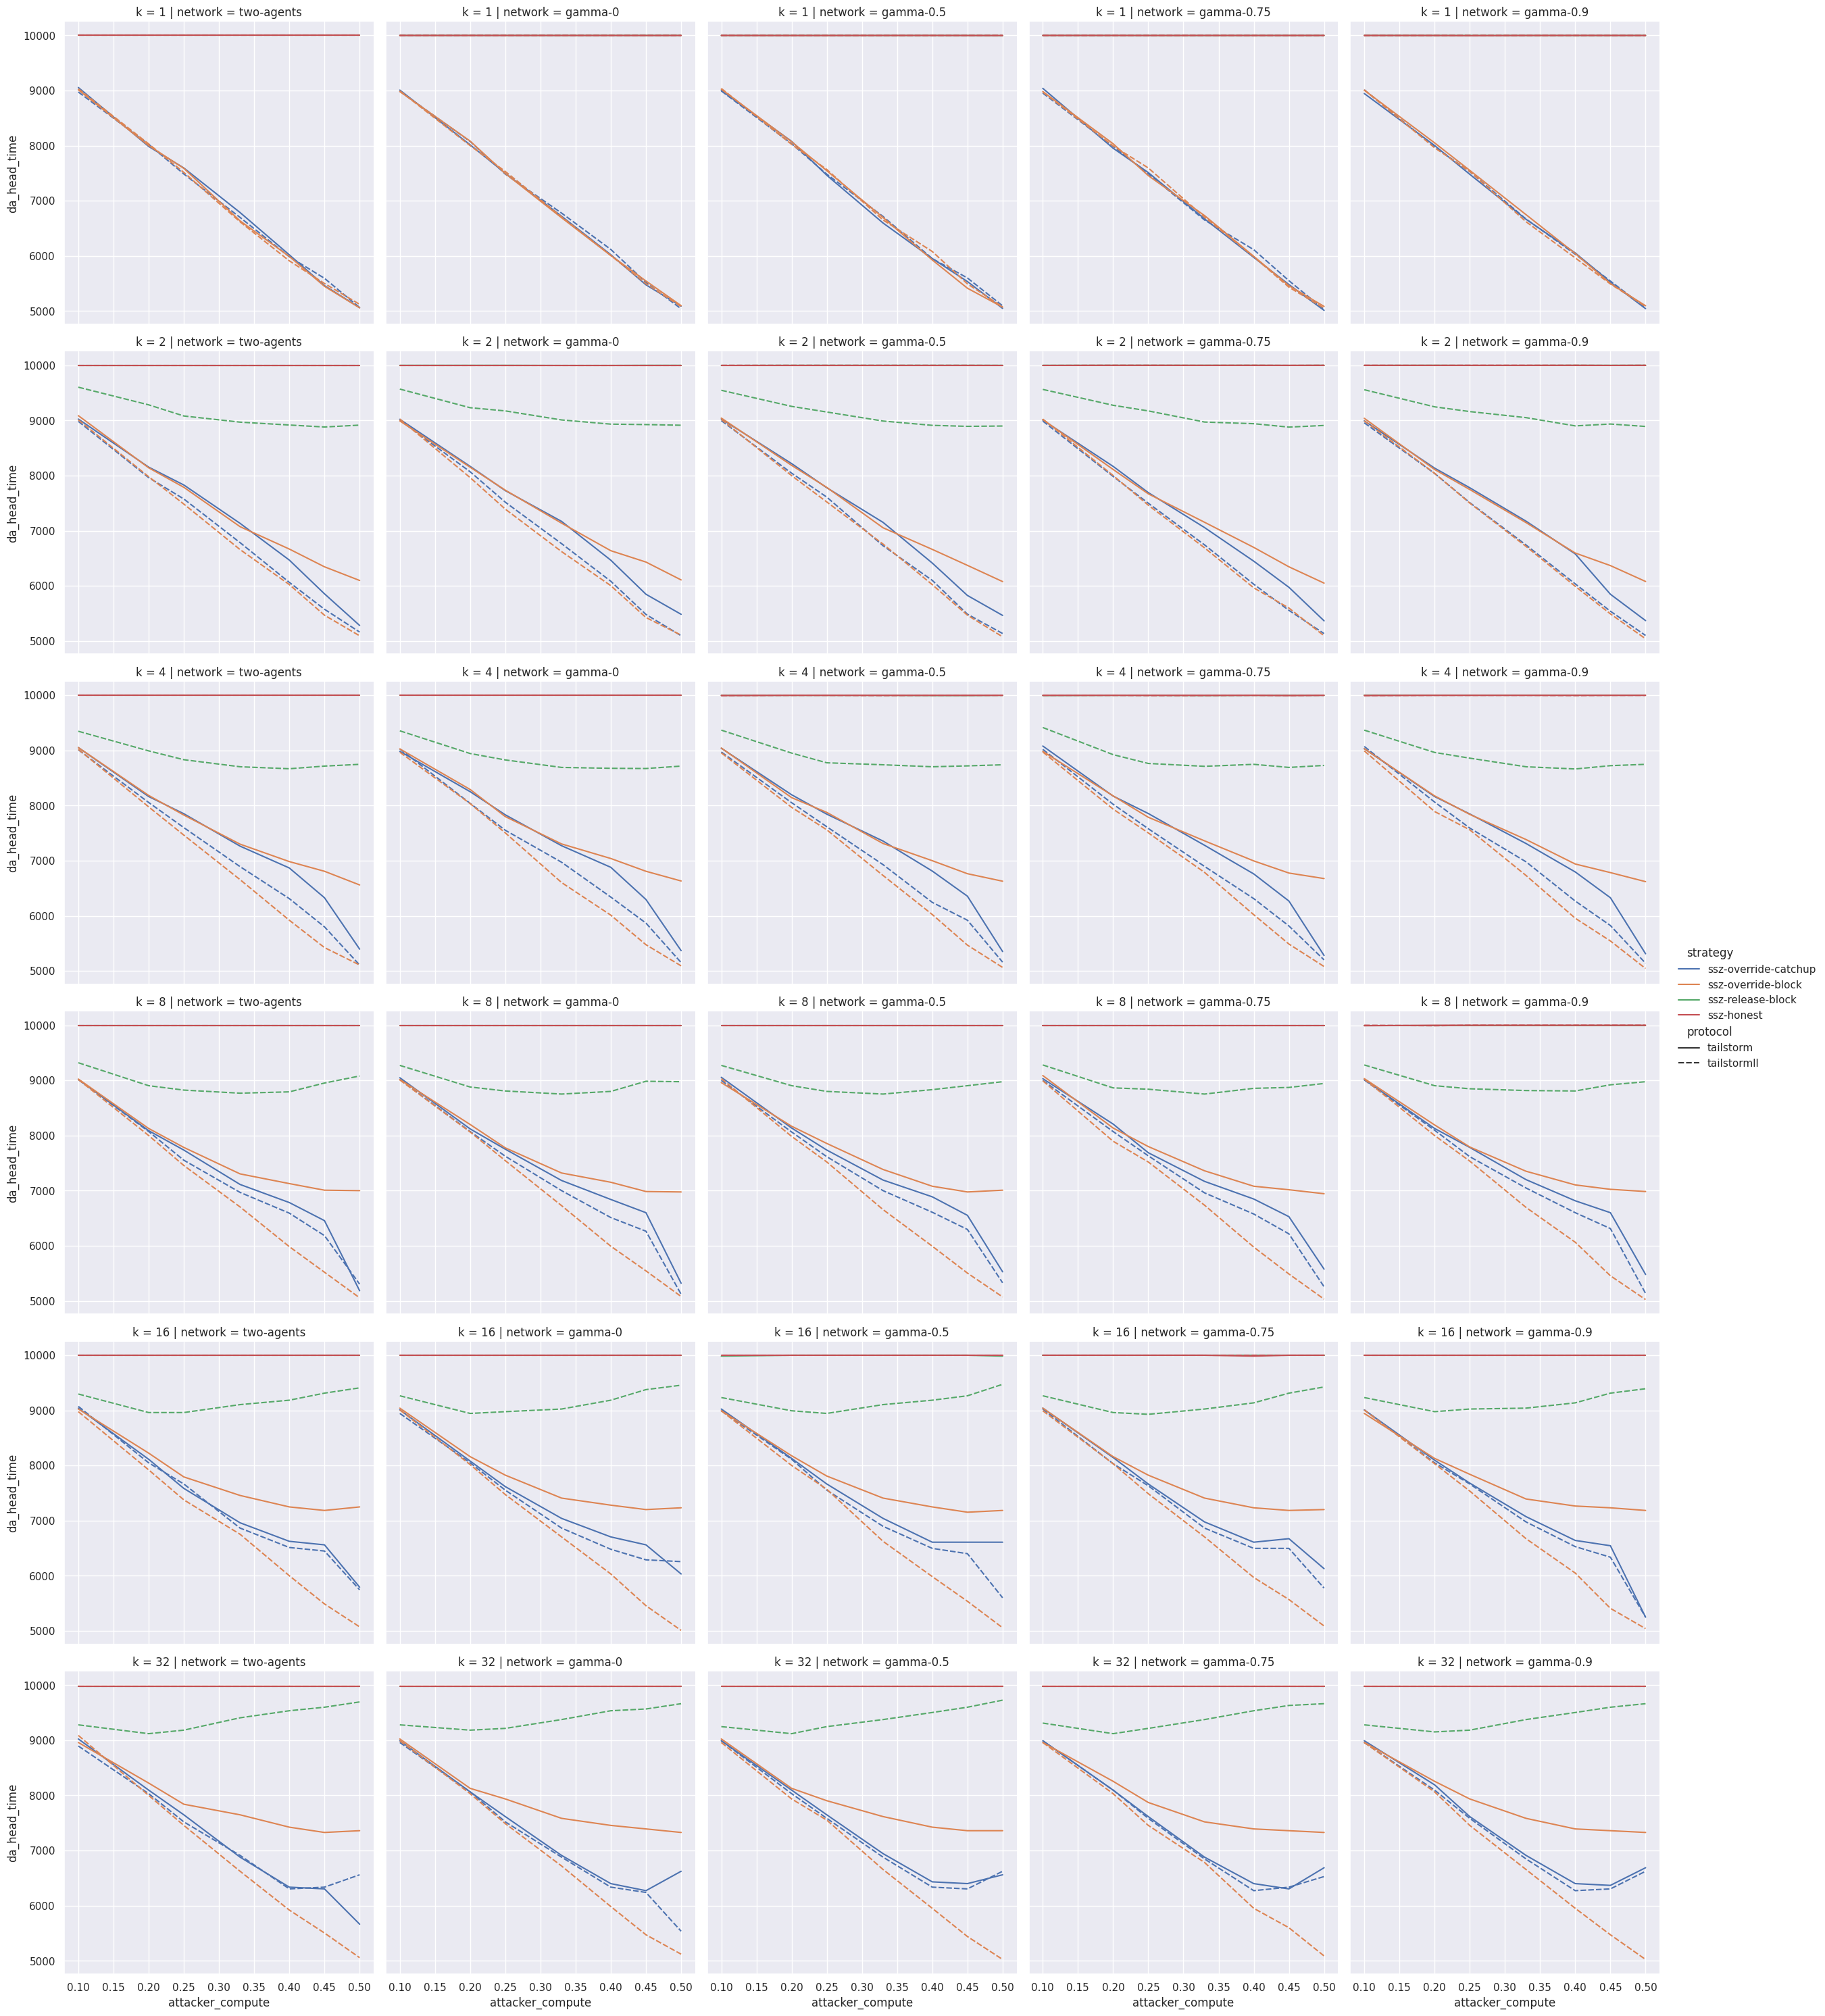

In [6]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_head_time",
    row="k",
    col="network",
    hue="strategy",
    style="protocol",
    kind="line",
)

The differences are plausible. I guess that some attack strategies make less sense for one protocol implementation or the other.

Let's compare rewards across protocol implementation. It should be the same, otherwise there is a bug in the new protocol implementation, its attack space, or policies.

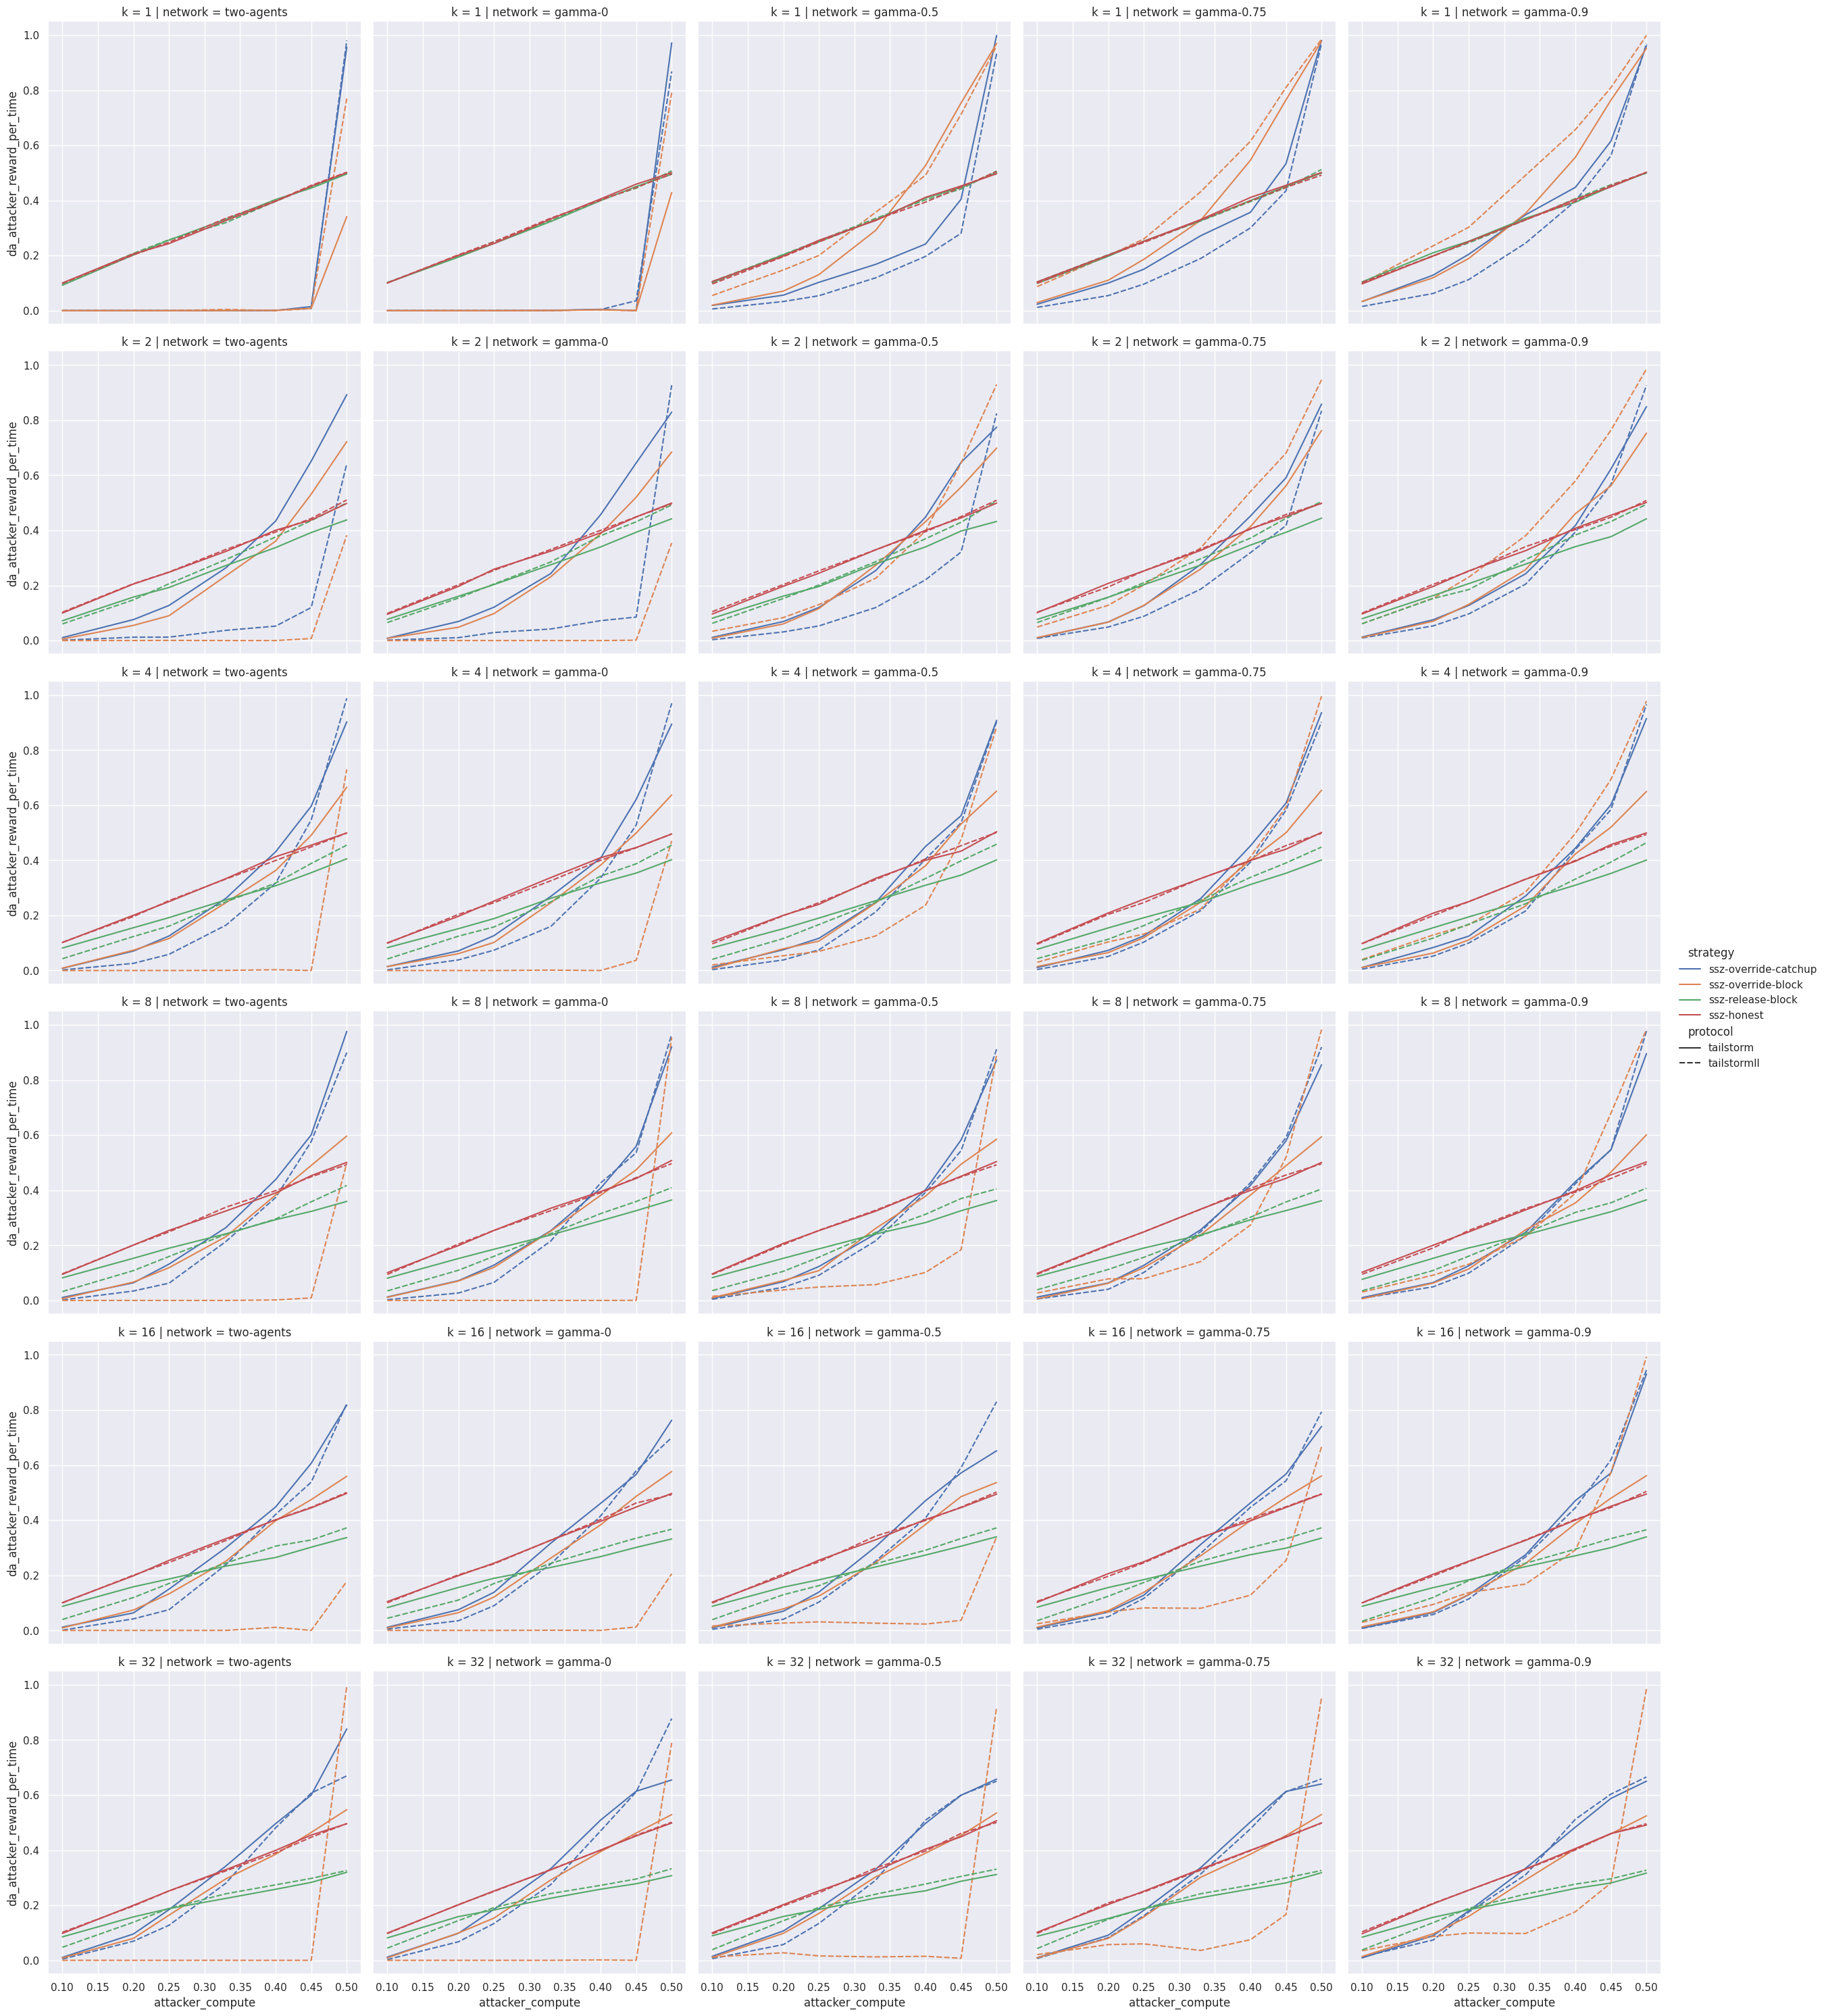

In [7]:
ax = sns.relplot(
    data=d.query('attack_space == "ssz" and incentive_scheme == "discount"'),
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    row="k",
    col="network",
    hue="strategy",
    style="protocol",
    kind="line",
)

Things look good. I guess the remaining issues are due to the policies beeing optimized for one protocol only.

---

I'm producing some figures here for a report somewhere in the git repo. At some point it should be revised though.

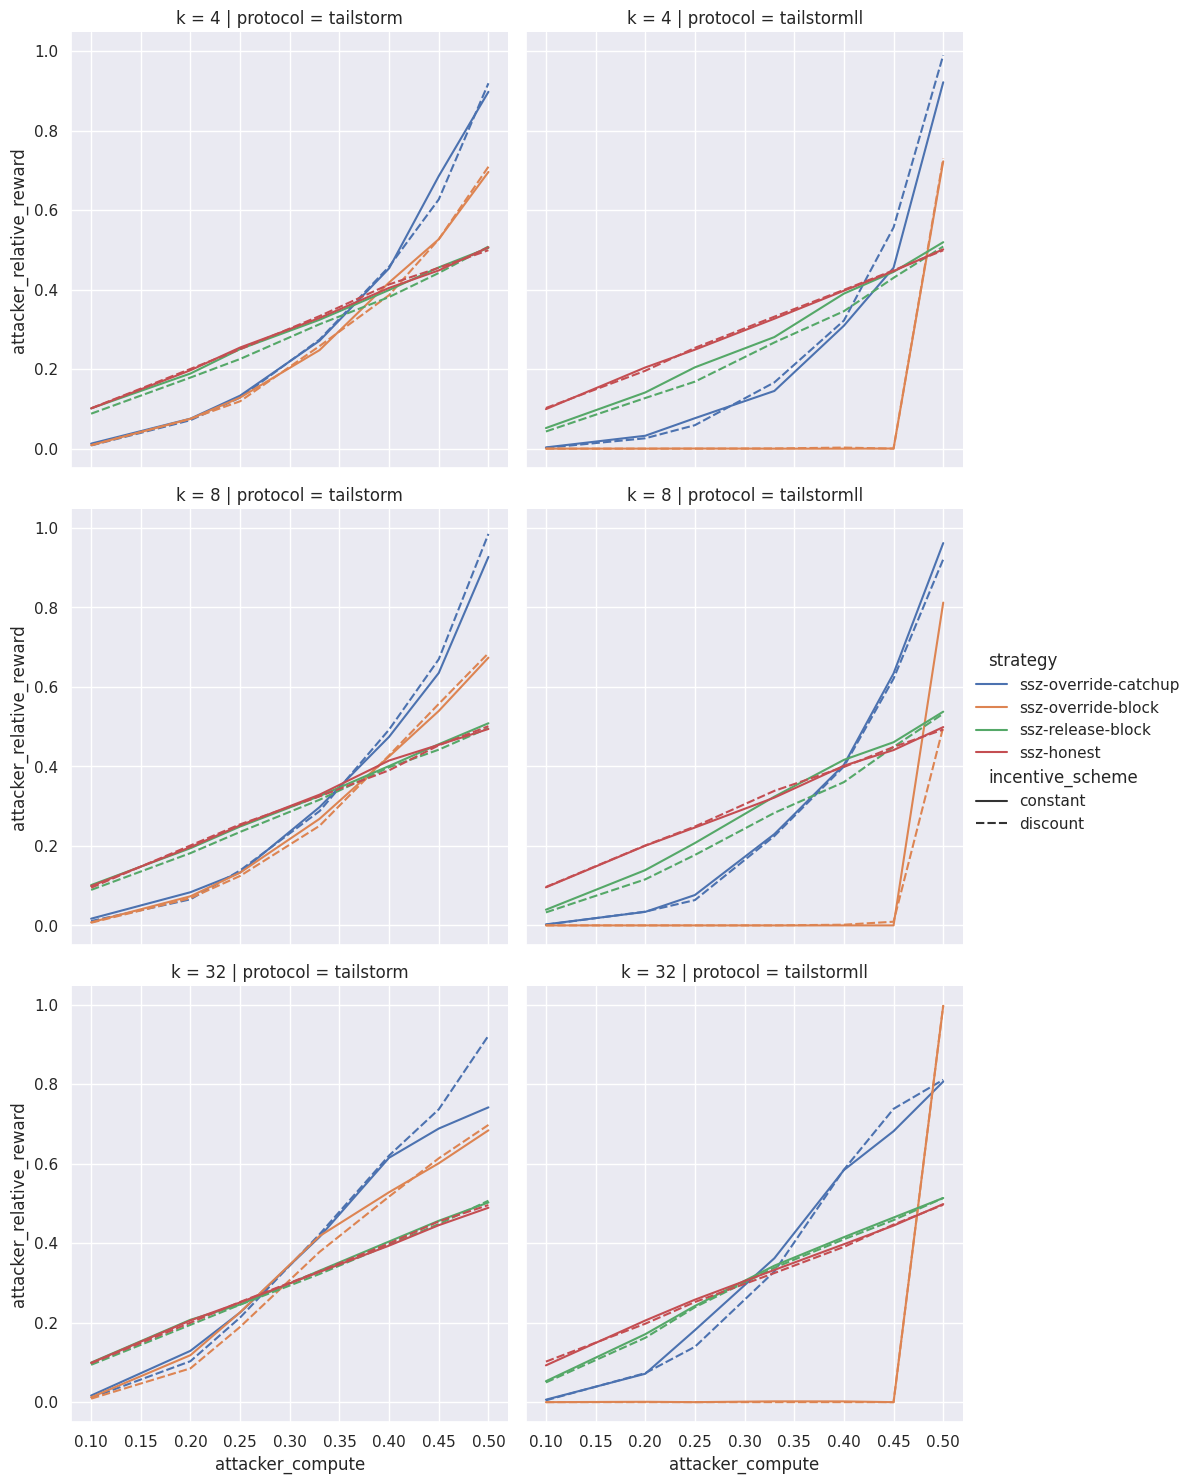

In [8]:
ax = sns.relplot(
    data=d.query('network == "two-agents" and k in [4, 8, 32]'),
    x="attacker_compute",
    y="attacker_relative_reward",
    row="k",
    col="protocol",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

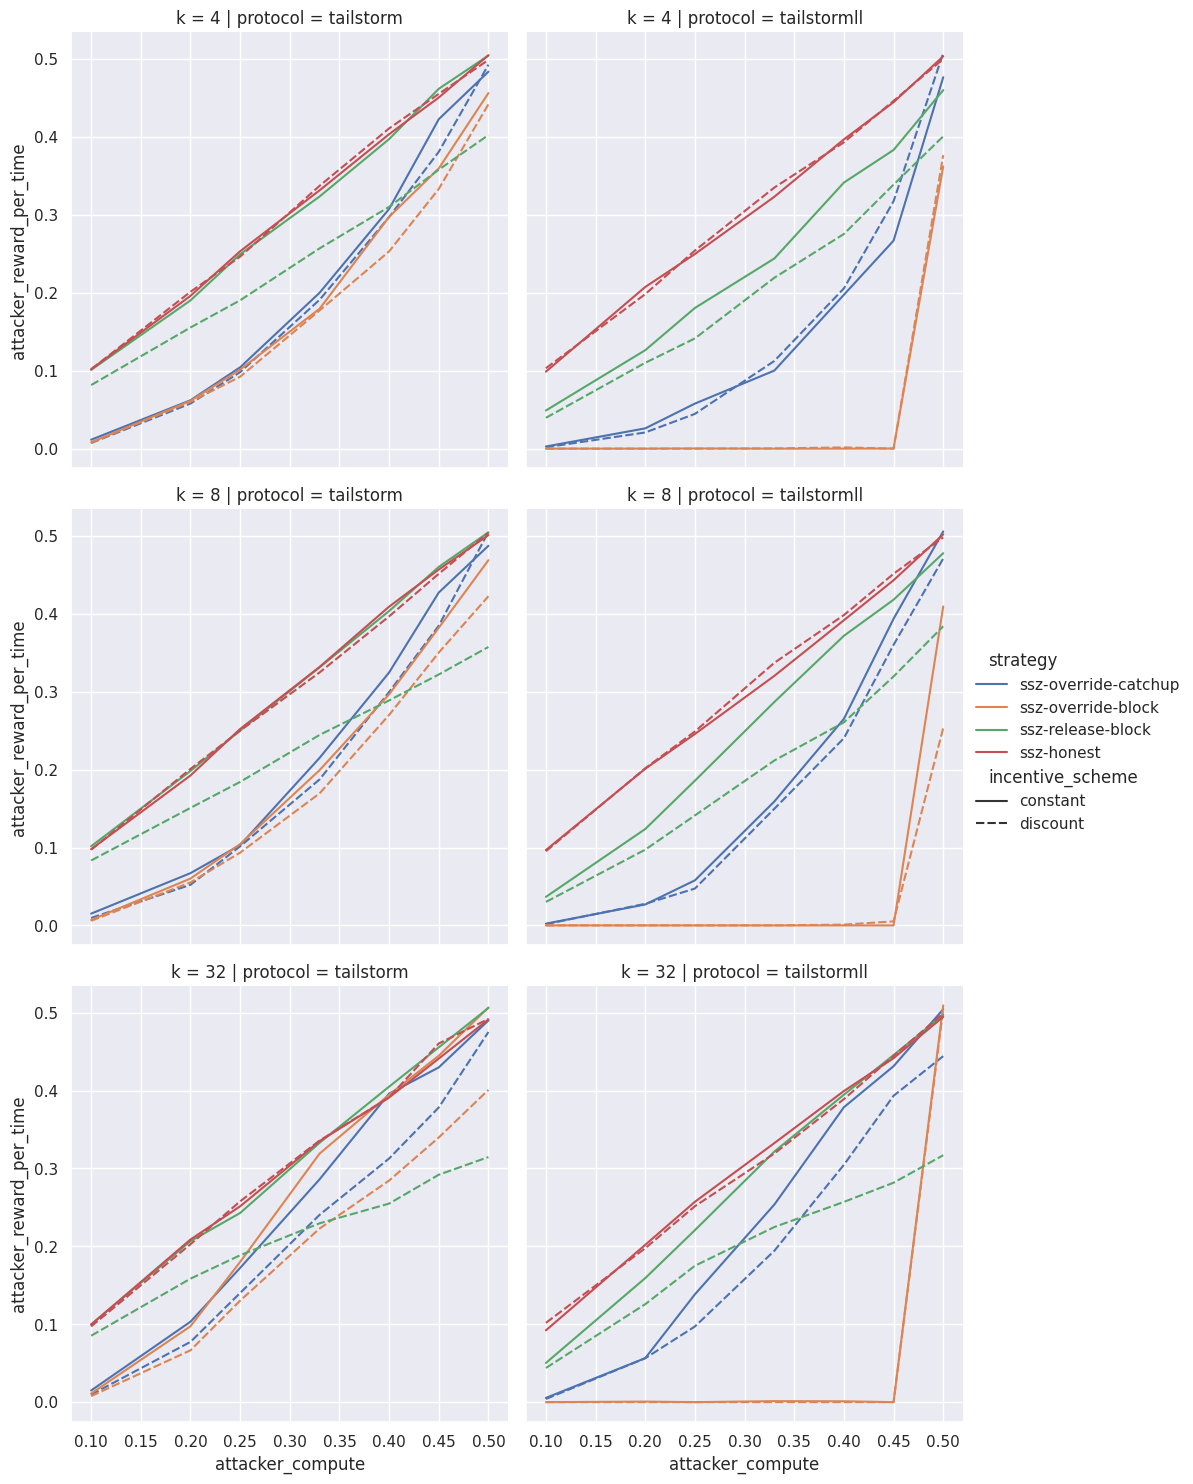

In [9]:
ax = sns.relplot(
    data=d.query('network == "two-agents" and k in [4, 8, 32]'),
    x="attacker_compute",
    y="attacker_reward_per_time",
    row="k",
    col="protocol",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

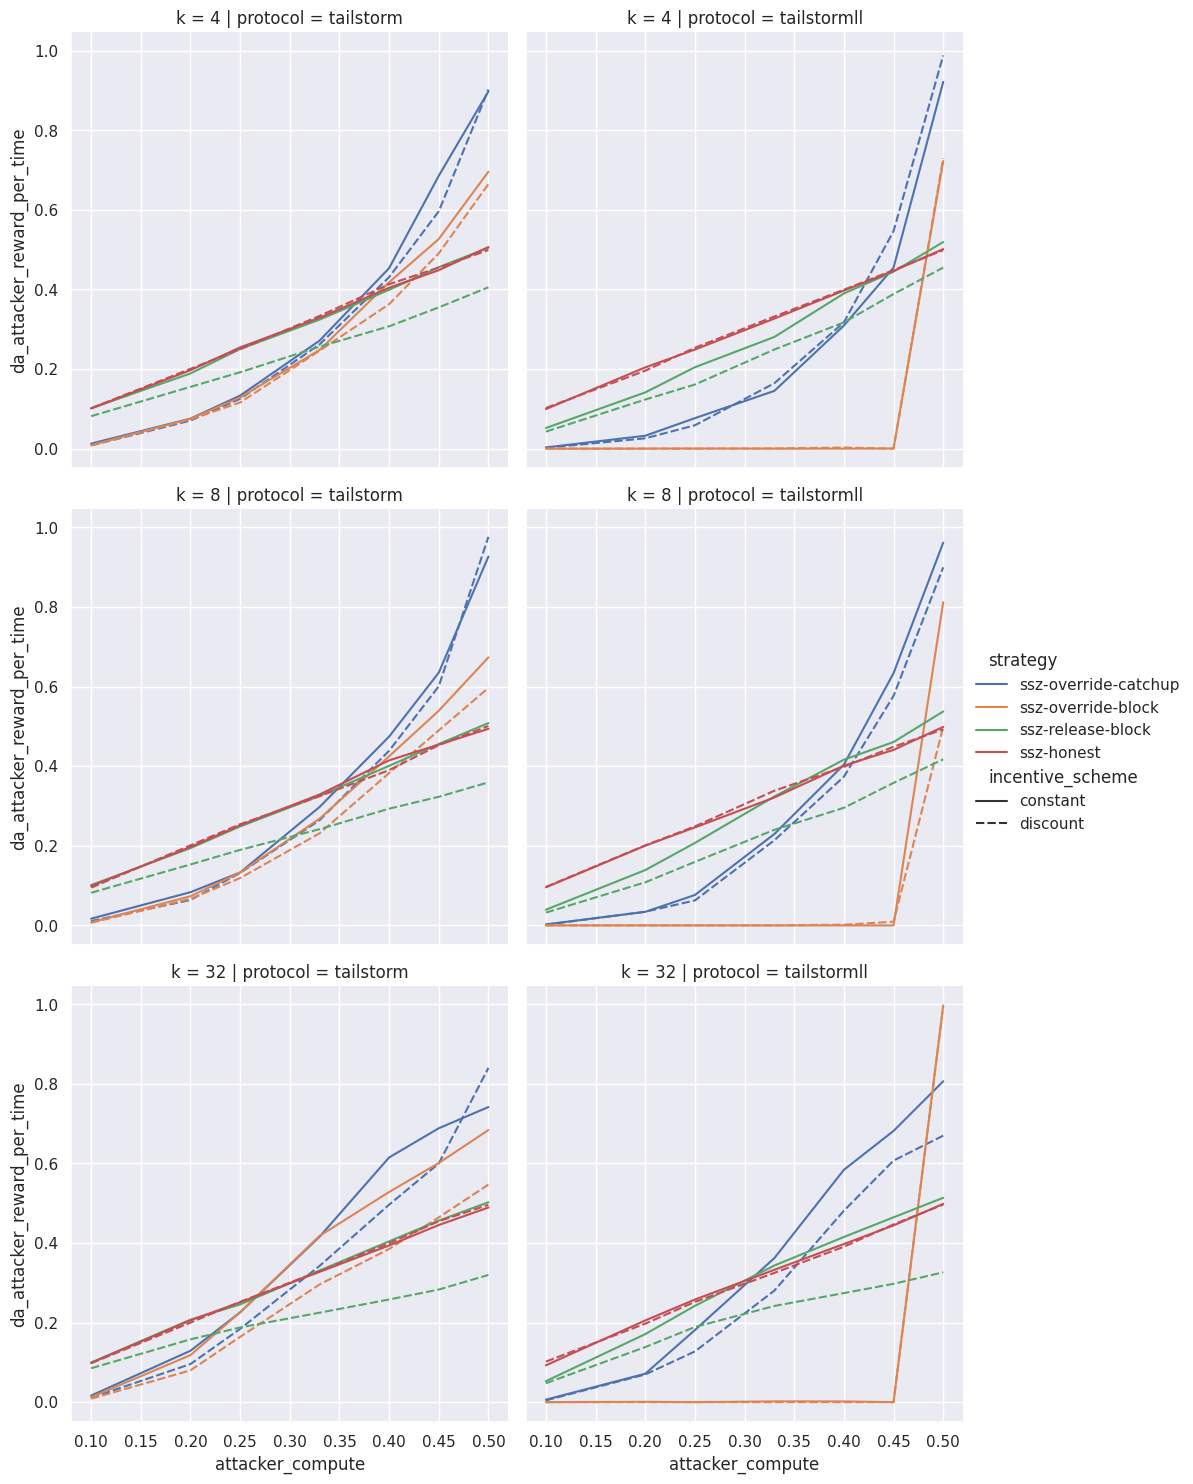

In [10]:
ax = sns.relplot(
    data=d.query('network == "two-agents" and k in [4, 8, 32]'),
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    row="k",
    col="protocol",
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

Comparision of attack spaces for Tailstorm/ll with emulated difficulty adjustment. This suggests that the ssz attack space is more powerfull than the old draft attack space. It also seems, that discount has an effect.